<a href="https://colab.research.google.com/github/FeliciaChin/Text-Classification-for-Major-Depressive-Disorder-MDD-Symptoms-and-Treatments-Using-Convolutional-/blob/main/DEMO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation of Package

In [ ]:
!pip install biopython
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.7 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Dataset Collection
from Bio import Entrez
from google.colab import files

# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D, GlobalMaxPool1D, BatchNormalization, Add
from keras.optimizers import Adam
from keras.models import Model, Sequential
from sklearn.model_selection  import train_test_split

# For custom metrics
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

# Visualization
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Download required resources for NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Data Collection and Data Preprocessing

##Dataset Collection

In [ ]:
# Set your email address (required by NCBI)
Entrez.email = "feliciac552@gmail.com"

# Define search terms
search_terms = "major depressive disorder AND symptoms AND treatments"
start_year = "2019"
end_year = "2023"

# Perform the search
handle = Entrez.esearch(db="pubmed", term=search_terms, retmax=5000, mindate=start_year, maxdate=end_year)
record = Entrez.read(handle)
handle.close()

In [ ]:
id_list = record["IdList"]
summary_records = []

# Create a list to store the extracted data
data = []

# Create a set to store the processed PMIDs
processed_pmids = set()

for article_id in id_list:
  if article_id in processed_pmids:
      continue

  try:
      handle = Entrez.efetch(db='pubmed', id=article_id, retmode='xml')
      article = Entrez.read(handle)['PubmedArticle'][0]
      handle.close()

      title = article['MedlineCitation']['Article']['ArticleTitle']
      abstract = article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')

      # Convert abstract to string
      abstract = str(abstract)

      # Append the extracted data to the list
      data.append({'Title': title, 'Abstract':abstract})

  except Exception as e:
        print(f"Error occurred for article ID {article_id}: {str(e)}")
        continue


In [ ]:
import csv
# Specify the output CSV file path
csv_file = 'major_depressive_disorder_datasets.csv'

# Write the data to the CSV file
with open(csv_file, 'w', newline='') as file:
    fieldnames = ['Title', 'Abstract']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(data)

print("Data saved to:", csv_file)

Data saved to: 2000_major_depressive_disorder_datasets.csv


In [ ]:
from google.colab import files

# Download the file
files.download('major_depressive_disorder_datasets.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Splitting Abstract into Sentences

In [ ]:
# Upload dataset
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]
# Read the CSV file
df = pd.read_csv(file_name)

Saving new_major_depressive_disorder_datasets.csv to new_major_depressive_disorder_datasets.csv


In [ ]:
df.shape

(4984, 2)

In [ ]:
df.head(10)

,Title,Abstract
0,Prevalence of and optimal screening tool for p...,[StringElement('Postpartum depression (PPD) is...
1,Impact of living with an adult with depressive...,[StringElement('The effect of depressive sympt...
2,Longitudinal Clusters of Long-Term Trajectorie...,"[StringElement('In clinical trials, mostly gro..."
3,Evaluating real-world effectiveness of acceler...,[StringElement('To assess the effectiveness of...
4,A prospective cohort study to assess the preva...,"[""Antepartum depression (APD) is a public heal..."
5,Effect of Psychological and Medication Therapi...,[StringElement('Daytime functional impairments...
6,Long-Term Safety and Efficacy of Initial and R...,['<b><i>Objective:</i></b> Zuranolone is a pos...
7,Impact of deep transcranial magnetic stimulati...,[StringElement('Deep transcranial magnetic sti...
8,Female-specific pharmacotherapy in ADHD: preme...,[StringElement('Attention-Deficit/Hyperactivit...
9,GABAA Receptor Availability in Relation to Cor...,[StringElement('Gamma-aminobutyric acid (GABA)...


In [ ]:
# Split abstract into sentences
sentences_list = []
for abstract in df["Abstract"]:
    sentences = nltk.sent_tokenize(str(abstract))
    sentences_list.extend(sentences)

# Create a new DataFrame with only the sentences column
sentences_df = pd.DataFrame(sentences_list, columns=["sentences"])

# Save the sentences DataFrame to a new CSV file
sentences_df.to_csv("mdd_sentences_dataset.csv", index=False)


In [ ]:
# Download the CSV file
files.download("mdd_sentences_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentences_df.head(10)

,sentences
0,[StringElement('Postpartum depression (PPD) is...
1,China is planning to launch PPD screening in c...
2,"', attributes={'Label': 'BACKGROUND', 'NlmCate..."
3,Video structured diagnostic interviews were pe...
4,Optimal screening was determined based on the ...
5,"', attributes={'Label': 'METHODS', 'NlmCategor..."
6,"Among those screened, the video structured dia..."
7,The optimal screening approach involved combin...
8,"', attributes={'Label': 'RESULTS', 'NlmCategor..."
9,"', attributes={'Label': 'LIMITATIONS', 'NlmCat..."


## Text preprocessing

In [ ]:
# Check for NaN values in the DataFrame
nan_values = sentences_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)


sentences    0
dtype: int64


In [ ]:
# Remove rows with NaN values
sentences_df.dropna(subset=["sentences"], inplace=True)

In [ ]:
# Re-check for NaN values in the DataFrame
nan_values = sentences_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)

sentences    0
dtype: int64


In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text = " ".join(tokens)

    return processed_text

# Apply preprocessing to the "sentences" column
sentences_df["sentences"] = sentences_df["sentences"].apply(preprocess_text)

# Save the preprocessed data to a CSV file
sentences_df.to_csv("mdd_preprocessed_data.csv", index=False)


In [ ]:
sentences_df.head(10)

,sentences
0,stringelementpostpartum depression ppd importa...
1,china planning launch ppd screening community ...
2,attributeslabel background nlmcategory backgro...
3,video structured diagnostic interview performe...
4,optimal screening determined based acceptabili...
5,attributeslabel method nlmcategory method stri...
6,among screened video structured diagnostic int...
7,optimal screening approach involved combining ...
8,attributeslabel result nlmcategory result stri...
9,attributeslabel limitation nlmcategory conclus...


In [ ]:
# Download the CSV file
files.download("mdd_preprocessed_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

preprocessed_df = pd.read_csv('mdd_preprocessed_data.csv')

Saving mdd_preprocessed_data.csv to mdd_preprocessed_data (1).csv


In [ ]:
preprocessed_df = pd.read_csv('mdd_preprocessed_data.csv')

In [ ]:
# Chekcing null values in the dataset
preprocessed_df.isnull().sum()

sentences    138
dtype: int64

In [ ]:
# Drop the column
preprocessed_df.dropna(subset=['sentences'], inplace=True)

# Resetting the index
preprocessed_df.reset_index(drop=True, inplace=True)

In [ ]:
# recheck null values in the dataset
preprocessed_df.isnull().sum()

sentences    0
dtype: int64

In [ ]:
preprocessed_df.shape

(58461, 1)

##Dataset Labeling

In [ ]:
# Define the symptoms and treatments keywords
symptoms_keywords = [
    "Aches",
    "pains",
    "Anxious",
    "Appetite changes",
    "Cramps",
    "decreased concentration",
    "Decreased energy",
    "depressed mood",
    "Difficulty concentrating",
    "Difficulty making decisions",
    "Difficulty Remembering",
    "Difficulty sleeping",
    "digestive problems without a clear physical cause",
    "disrupted sleep",
    "do not ease even with treatment",
    "early-morning awakening",
    "empty mood",
    "excessive guilt",
    "fatigue",
    "Feeling restless",
    "feeling very tired",
    "feelings of excessive guilt",
    "Feelings of guilt",
    "Feelings of hopelessness",
    "having trouble sitting still",
    "headaches",
    "helplessness",
    "hopelessness about the future",
    "hypersomnia",
    "Insomnia",
    "Irritability",
    "Loss of interest",
    "loss of pleasure",
    "low in energy",
    "low self-worth",
    "oversleeping",
    "Persistent sadness",
    "pessimism",
    "poor concentration",
    "psychomotor agitation",
    "retardation",
    "suicide attempts",
    "thoughts about dying",
    "thoughts of suicide",
    "weight changes",
    "weight gain",
    "weight loss",
    "Worthlessness"
]


treatments_keywords = [
    "antidepressants",
    "Atypical antidepressants",
    "behavioural activation",
    "cognitive behavioural therapy",
    "Electroconvulsive therapy",
    "ECT"
    "fluoxetine",
    "interpersonal psychotherapy",
    "Monoamine oxidase inhibitors",
    "MAOIs",
    "neuromodulation",
    "problem-solving therapy",
    "Psychotherapy",
    "Selective serotonin reuptake inhibitors",
    "SSRIs",
    "Serotonin-norepinephrine reuptake inhibitors",
    "SNRIs",
    "Transcranial magnetic stimulation",
    "Tricyclic antidepressants"
]


In [ ]:
# Preprocessing keywords
def preprocess_keyword(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_keywords = " ".join(tokens)

    return processed_keywords


# Preprocess the keywords using the preprocess_text function
symptoms_keywords = [preprocess_keyword(keyword) for keyword in symptoms_keywords]
treatments_keywords = [preprocess_keyword(keyword) for keyword in treatments_keywords]


In [ ]:
# Print the keywords
print("Preprocessed Symptoms Keywords:")
for keyword in symptoms_keywords:
    print(keyword)

print("\nPreprocessed Treatments Keywords:")
for keyword in treatments_keywords:
    print(keyword)

Preprocessed Symptoms Keywords:
ache
pain
anxious
appetite change
cramp
decreased concentration
decreased energy
depressed mood
difficulty concentrating
difficulty making decision
difficulty remembering
difficulty sleeping
digestive problem without clear physical cause
disrupted sleep
ease even treatment
early-morning awakening
empty mood
excessive guilt
fatigue
feeling restless
feeling tired
feeling excessive guilt
feeling guilt
feeling hopelessness
trouble sitting still
headache
helplessness
hopelessness future
hypersomnia
insomnia
irritability
loss interest
loss pleasure
low energy
low self-worth
oversleeping
persistent sadness
pessimism
poor concentration
psychomotor agitation
retardation
suicide attempt
thought dying
thought suicide
weight change
weight gain
weight loss
worthlessness

Preprocessed Treatments Keywords:
antidepressant
atypical antidepressant
behavioural activation
cognitive behavioural therapy
electroconvulsive therapy
ectfluoxetine
interpersonal psychotherapy
monoa

In [ ]:
labeled_data = pd.DataFrame()
labeled_data['sentences'] = preprocessed_df['sentences']

In [ ]:
# Resetting index of labeled_data
labeled_data.reset_index(drop=True, inplace=True)

In [ ]:
labeled_data.shape

(58461, 1)

In [ ]:
labeled_data.isnull().sum()

sentences    0
dtype: int64

In [ ]:
preprocessed_df.shape

(58461, 1)

In [ ]:
sentences = preprocessed_df['sentences']

# Create a new column for labels
labeled_data['label'] = 0

# Initialize dictionaries to store the matched symptom and treatment words for each sentence
symptom_words_dict = {}
treatment_words_dict = {}

# Define a function to get the n-gram of a keyword
def get_keyword_ngram(keyword):
    # Split the keyword by spaces and count the number of elements
    ngram = len(keyword.split())
    return ngram

# Loop through the test sentences
for i, sentence in enumerate(sentences,0):
    # Tokenize the preprocessed sentence into words
    words = nltk.word_tokenize(sentence)

    if sentence != labeled_data.loc[i, 'sentences']:
        print(f"Sentence {i}: {sentence}")

    # Initialize flags for symptom and treatment
    symptom_flag = False
    treatment_flag = False

    # Initialize lists to store the matched symptom and treatment words for this sentence
    symptom_words_dict[i] = []
    treatment_words_dict[i] = []

    # Loop through the keywords
    for keyword in symptoms_keywords + treatments_keywords:
        # Preprocess the keyword and get the n-gram
        ngram = get_keyword_ngram(keyword)

        # Generate n-grams of the appropriate length
        sentence_ngrams = list(ngrams(words, ngram))

        # Check if the keyword is in the sentence n-grams
        for gram in sentence_ngrams:
            if keyword == ' '.join(gram):
                matched_word = ' '.join(gram)
                if keyword in symptoms_keywords:
                    symptom_flag = True
                    symptom_words_dict[i].append(matched_word)  # Store the matched word
                if keyword in treatments_keywords:
                    treatment_flag = True
                    treatment_words_dict[i].append(matched_word)  # Store the matched word

    # Assign labels and print the results for label 3 only
    if symptom_flag and treatment_flag:
        labeled_data.loc[i, 'label'] = 3
    elif symptom_flag:
        labeled_data.loc[i, 'label'] = 1
    elif treatment_flag:
        labeled_data.loc[i, 'label'] = 2
    elif not symptom_flag and not treatment_flag:
        labeled_data.loc[i, 'label'] = 0

In [ ]:
preprocessed_df.loc[86, 'sentences']

'attributeslabel unlabelled stringelementchopra singal p kodya impact deep transcranial magnetic stimulation insomnia outcome patient treatmentresistant depression retrospective study'

In [ ]:
labeled_data.head(10)

,sentences,label
0,stringelementpostpartum depression ppd importa...,0
1,china planning launch ppd screening community ...,0
2,attributeslabel background nlmcategory backgro...,0
3,video structured diagnostic interview performe...,0
4,optimal screening determined based acceptabili...,0
5,attributeslabel method nlmcategory method stri...,0
6,among screened video structured diagnostic int...,0
7,optimal screening approach involved combining ...,0
8,attributeslabel result nlmcategory result stri...,0
9,attributeslabel limitation nlmcategory conclus...,0


In [ ]:
# Get the sentence at index 2906
sentence = labeled_data.loc[22209, 'sentences']

# Print the sentence
print(sentence)

app cover five cbt skill cognitive restructuring behavioural activation problemsolving assertion training behaviour therapy insomnia


In [ ]:
# Get the indices of sentences labeled as 3
indices = labeled_data[(labeled_data['symptoms'] == 1) & (labeled_data['treatments'] == 1)].index

# Loop through the indices
for i in indices:
    print(f"Sentence {i}:")
    print("Text:", sentences[i])  # Print the sentence
    print("Symptom words:", symptom_words_dict[i])
    print("Treatment words:", treatment_words_dict[i])
    print()


Sentence 86:
Text: attributeslabel unlabelled stringelementchopra singal p kodya impact deep transcranial magnetic stimulation insomnia outcome patient treatmentresistant depression retrospective study
Symptom words: ['insomnia']
Treatment words: ['transcranial magnetic stimulation']

Sentence 1469:
Text: effect size reported standardized mean difference smds odds ratio or confidence interval ci
Symptom words: ['insomnia']
Treatment words: ['antidepressant']

Sentence 1472:
Text: active nib intervention exhibited significant difference dropout side effect rate compared sham control
Symptom words: ['insomnia']
Treatment words: ['antidepressant']

Sentence 1973:
Text: bintroductionb selective serotonin reuptake inhibitor ssri often used medication treat major depressive disorder mdd
Symptom words: ['insomnia']
Treatment words: ['ssri']

Sentence 3717:
Text: patient trd often comorbid personality disorder pd evidence suggests association sleep disturbance recovery among patient pd
Symptom

In [ ]:
# Save the DataFrame to a CSV file
labeled_data.to_csv('mdd_labeled_data.csv', index=False)
from google.colab import files

# Download the file
files.download('mdd_labeled_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Exploratory Data Analysis

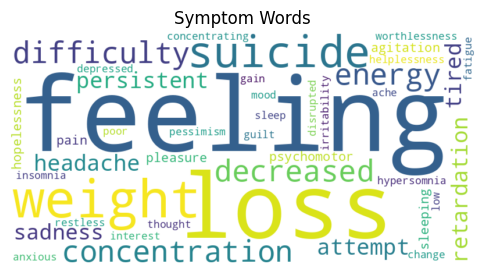

In [ ]:
# Flatten the symptom_words_dict into a list
symptom_words_flat = [word for words in symptom_words_dict.values() for word in words]
treatment_words_flat = [word for words in treatment_words_dict.values() for word in words]

# Remove duplicate occurrences
symptom_words_unique = list(set(symptom_words_flat))
treatment_words_unique = list(set(treatment_words_flat))

# Generate word cloud for symptom words without duplicates
symptom_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(symptom_words_unique))
treatment_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(treatment_words_unique))

# Plot the symptoms word cloud
plt.figure(figsize=(6, 4))
plt.imshow(symptom_wordcloud_unique, interpolation='bilinear')
plt.title('Symptom Words')
plt.axis('off')
plt.show()


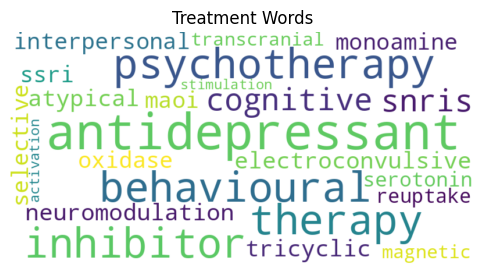

In [ ]:
# Plot the treatments word cloud
plt.figure(figsize=(6, 4))
plt.imshow(treatment_wordcloud_unique, interpolation='bilinear')
plt.title('Treatment Words')
plt.axis('off')
plt.show()

In [ ]:
# Count the occurrences of each label
label_counts = labeled_data['label'].value_counts()
print(label_counts)

label
0    53271
2     3399
1     1707
3       84
Name: count, dtype: int64


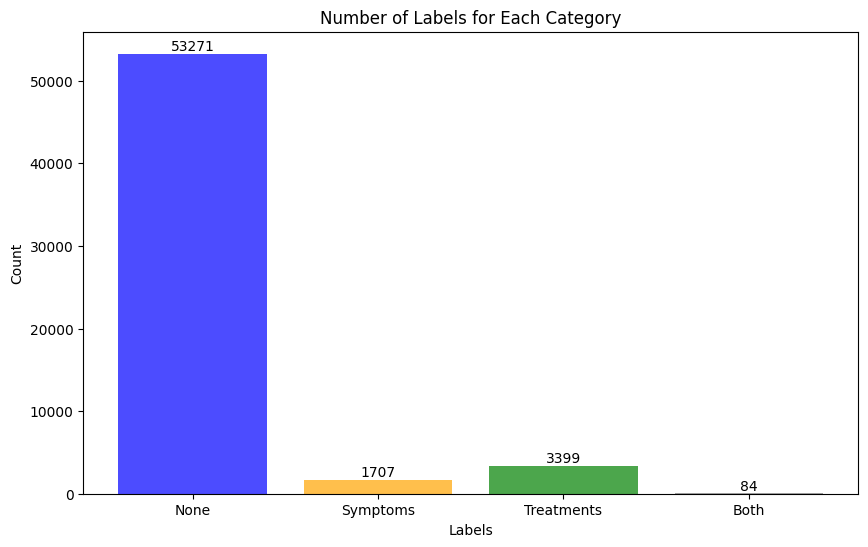

In [ ]:
# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange', 'grey']
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2, 3], ['None', 'Symptoms', 'Treatments', 'Both'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()


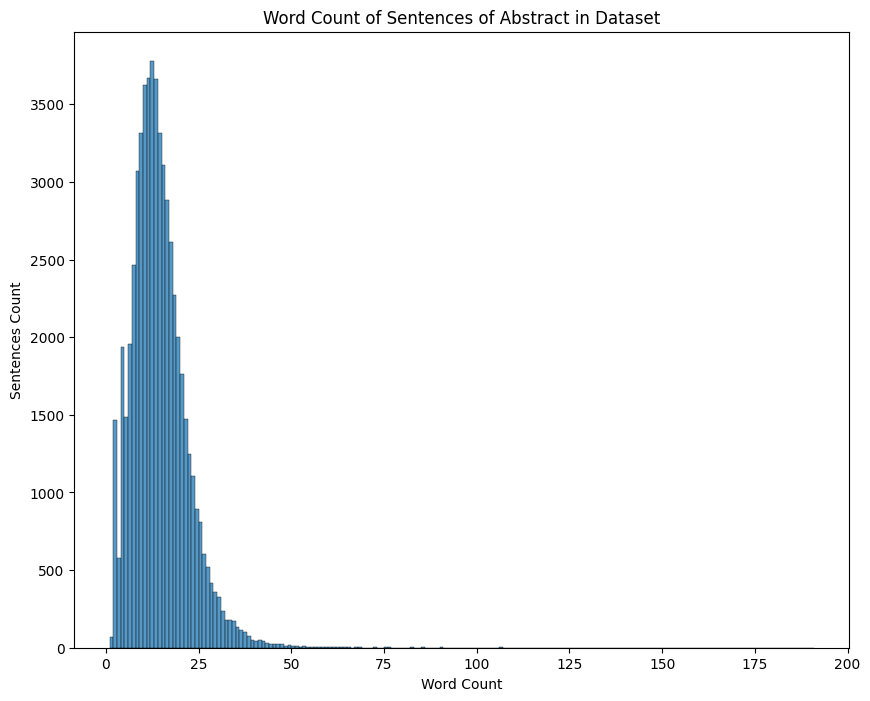

In [ ]:
# Calculate word count
word_count = labeled_data['sentences'].apply(lambda x: len(str(x).split()))

# Create histogram
plt.figure(figsize=(10,8))
hist = sns.histplot(data=labeled_data, x=word_count, binwidth=1)

plt.title('Word Count of Sentences of Abstract in Dataset')
plt.xlabel('Word Count')
plt.ylabel('Sentences Count')
plt.show()


In [ ]:
max_word_count = word_count.max()
print("The maximum word count is:", max_word_count)

The maximum word count is: 191


In [ ]:
sentences = (sum(word_count < 100)/labeled_data.shape[0])*100
print('Percentage of sentences having less than 100 Words:{:.2f}%'.format(sentences))


Percentage of sentences having less than 100 Words:99.99%


##Handle Imbalance Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]


Saving mdd_labeled_data.csv to mdd_labeled_data (1).csv


In [ ]:
# Read the CSV file
df = pd.read_csv(file_name)

In [ ]:
df.shape

(58461, 2)

In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()
print(label_counts)

label
0    53271
2     3399
1     1707
3       84
Name: count, dtype: int64


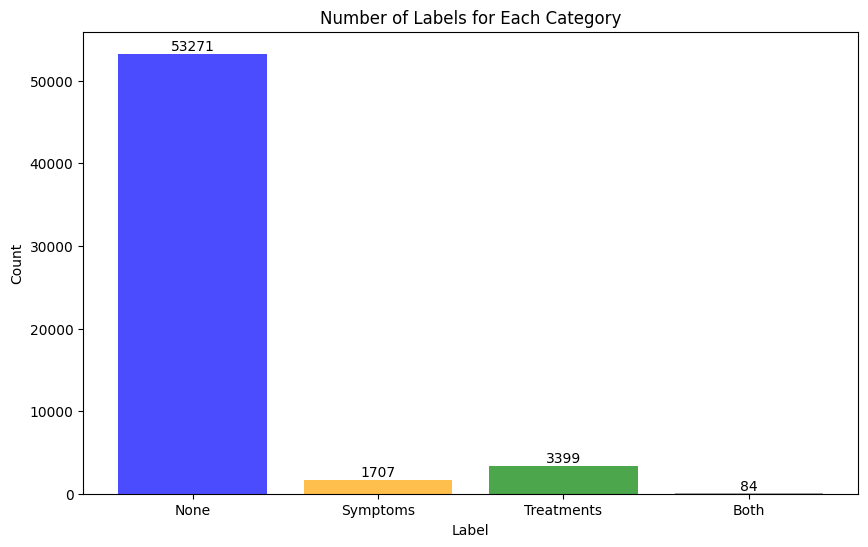

In [ ]:
# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange', 'grey']
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2, 3], ['None', 'Symptoms', 'Treatments', 'Both'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()


In [ ]:
none_treatment_symptoms = df[(df['label'] == 0)]
other_classes = df[(df['label'] != 0)]

# Randomly sample instances from 'none treatment and symptoms' class
reduced_none_treatment_symptoms = none_treatment_symptoms.sample(n=5000, random_state=1)

# Concatenate the reduced 'none treatment and symptoms' DataFrame wth the other classes DataFrame
balanced_df = pd.concat([reduced_none_treatment_symptoms, other_classes])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [ ]:
balanced_df.shape

(10190, 2)

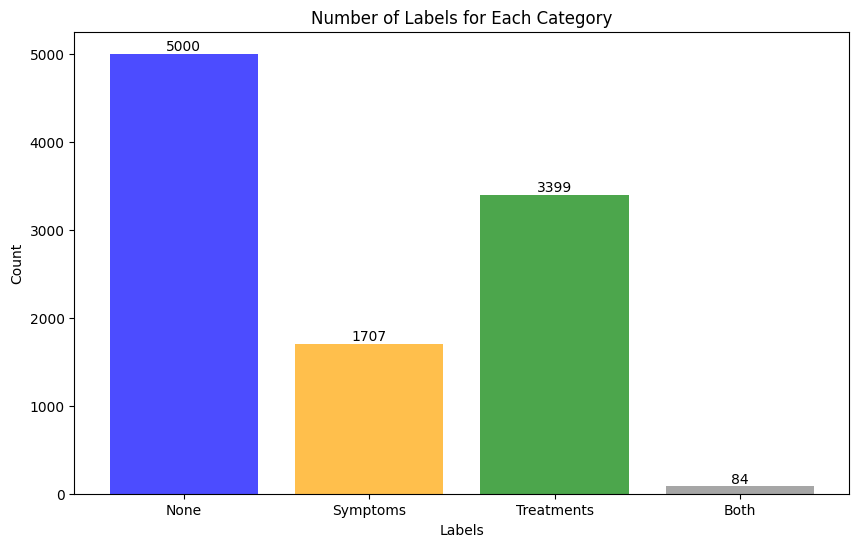

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'labeled_data' is your DataFrame and it has columns 'None', 'symptoms', and 'treatments'
counts = balanced_df['label'].value_counts()

# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange', 'grey']
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color=colors, alpha=0.7)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2, 3], ['None', 'Symptoms', 'Treatments', 'Both'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()



In [ ]:
balanced_df.shape

(10190, 2)

In [ ]:
balanced_df.head(10)

,sentences,label
0,biconclusionsib approximately onefourth elderl...,2
1,registered november,0
2,excluded analysis individual followed le year ...,0
3,multivariable logistic regression model provid...,1
4,treatment antidepressant patient fc index impr...,2
5,attributeslabel conclusion,0
6,classification performance significantly diffe...,0
7,session attended dropout rate treatment satisf...,0
8,study excluded case report systematic review c...,0
9,accuracy predicting nonresponse placebo treatm...,2


In [ ]:
# Save the DataFrame to a CSV file
balanced_df.to_csv('new_balanced_onelabeled_data.csv', index=False)
from google.colab import files

# Download the file
files.download('new_balanced_onelabeled_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Builidng

In [ ]:
from google.colab import files

uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]


Saving new_balanced_onelabeled_data.csv to new_balanced_onelabeled_data.csv


In [ ]:
# For sharp visualization
! pip install shap

import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
# Read the CSV file
df = pd.read_csv(file_name)

# Assuming your DataFrame 'df' has the structure as described
X = df['sentences']
y = df['label'].values

In [ ]:
num_words = 100 #Max. words to use per sentences
max_features = 100 #Max. number of unique words in embeddinbg vector
max_len = 100 #Max. number of words per sentences to be use
embedding_dims = 100 #embedding vector output dimension
num_epochs = 15
batch_size2 = 32

In [ ]:
df.head(5)

,sentences,label
0,biconclusionsib approximately onefourth elderl...,2
1,registered november,0
2,excluded analysis individual followed le year ...,0
3,multivariable logistic regression model provid...,1
4,treatment antidepressant patient fc index impr...,2


In [ ]:
#sentences Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X))

#Convert tokenized sentences to sequnces
X = tokenizer.texts_to_sequences(X)

# padding the sequences
X = sequence.pad_sequences(X, max_len)


In [ ]:
#split the dataset into train and test (train 70%, val 20% and test 10%).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# re-create train and validation set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# train 70%, validation 20%, test 10%
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7133, 100)
(2048, 100)
(1009, 100)


##Author CNN Model

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

In [ ]:
CNN_model_author = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
CNN_model_author.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_model_author.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 100, 100)          40100     
                                                                 
 batch_normalization (Batch  (None, 100, 100)          400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0

In [ ]:
CNN_model_author_fit = CNN_model_author.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
223/223 [==============================] - 11s 44ms/step - loss: 0.5477 - accuracy: 0.8225 - val_loss: 0.6870 - val_accuracy: 0.7993
Epoch 2/15
223/223 [==============================] - 8s 34ms/step - loss: 0.3664 - accuracy: 0.8906 - val_loss: 0.3236 - val_accuracy: 0.9111
Epoch 3/15
223/223 [==============================] - 8s 35ms/step - loss: 0.3248 - accuracy: 0.8986 - val_loss: 0.3035 - val_accuracy: 0.9146
Epoch 4/15
223/223 [==============================] - 9s 39ms/step - loss: 0.3278 - accuracy: 0.8965 - val_loss: 0.2921 - val_accuracy: 0.9131
Epoch 5/15
223/223 [==============================] - 7s 32ms/step - loss: 0.3134 - accuracy: 0.9021 - val_loss: 0.2747 - val_accuracy: 0.9146
Epoch 6/15
223/223 [==============================] - 10s 47ms/step - loss: 0.3065 - accuracy: 0.8999 - val_loss: 0.2833 - val_accuracy: 0.9131
Epoch 7/15
223/223 [==============================] - 7s 31ms/step - loss: 0.3005 - accuracy: 0.9021 - val_loss: 0.3071 - val_accuracy: 0.91

In [ ]:
CNN_author_train_score = CNN_model_author.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_author_train_score[0])
print('Train accuracy:', CNN_author_train_score[1])

223/223 [==============================] - 2s 8ms/step - loss: 0.2897 - accuracy: 0.9020
Train loss: 0.28972166776657104
Train accuracy: 0.9020047783851624


In [ ]:
CNN_author_test_score = CNN_model_author.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_author_test_score[0])
print('Test Accuracy:', CNN_author_test_score[1])

32/32 [==============================] - 0s 9ms/step - loss: 0.3088 - accuracy: 0.8940
Test Loss: 0.3088103234767914
Test Accuracy: 0.8939543962478638


### Visualization on Testing and Validation Result

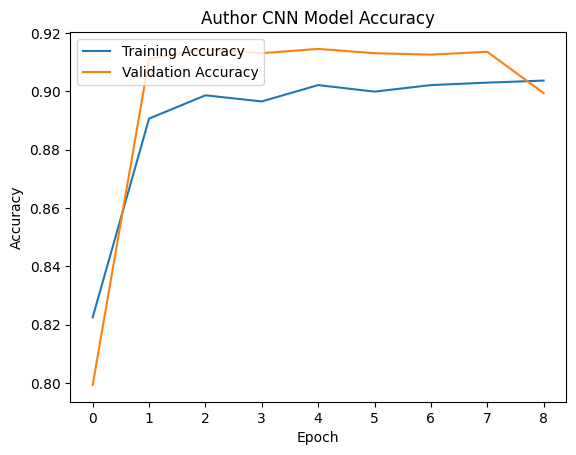

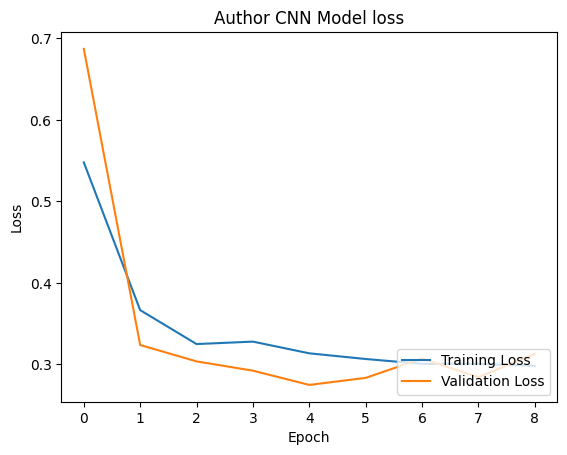

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_author_fit.history['accuracy'])
plt.plot(CNN_model_author_fit.history['val_accuracy'])
plt.title('Author CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_author_fit.history['loss'])
plt.plot(CNN_model_author_fit.history['val_loss'])
plt.title('Author CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Confusion Matrix

32/32 [==============================] - 0s 8ms/step


<ipython-input-20-da26eb9b30d2>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-20-da26eb9b30d2>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


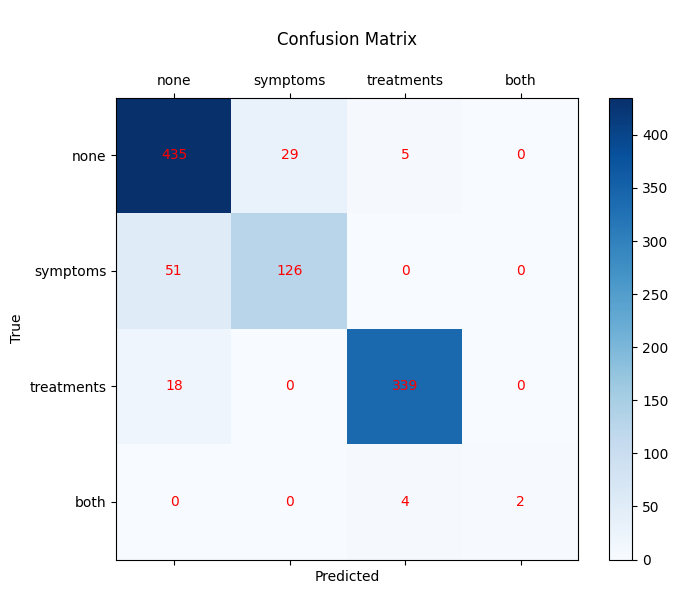

              precision    recall  f1-score   support

        none       0.86      0.93      0.89       469
    symptoms       0.81      0.71      0.76       177
  treatments       0.97      0.95      0.96       357
        both       1.00      0.33      0.50         6

    accuracy                           0.89      1009
   macro avg       0.91      0.73      0.78      1009
weighted avg       0.89      0.89      0.89      1009



In [ ]:
# Make predictions on the testing data
y_pred = CNN_model_author.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


In [ ]:
explainer = shap.Explainer(CNN_model_author.predict, X_val)
shap_values = explainer.shap_values(X_val)

In [ ]:
# Summarize features importants
shap.summary_plot(shap_values, X_val)

## Proposed CNN Model

*    using L2 Regularization (0,01)



In [ ]:
CNN_proposed_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(4, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_proposed_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
CNN_proposed_model.summary()
CNN_proposed_model_fit = CNN_proposed_model.fit(X_train, y_train, batch_size=64, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 100)              

In [ ]:
CNN_proposed_train_score = CNN_proposed_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_proposed_train_score[0])
print('Train accuracy:', CNN_proposed_train_score[1])

223/223 [==============================] - 2s 8ms/step - loss: 0.2726 - accuracy: 0.9153
Train loss: 0.27261948585510254
Train accuracy: 0.9153231382369995


In [ ]:
CNN_proposed_test_score = CNN_proposed_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_proposed_test_score[0])
print('Test Accuracy:', CNN_proposed_test_score[1])

32/32 [==============================] - 0s 8ms/step - loss: 0.2811 - accuracy: 0.9217
Test Loss: 0.28105229139328003
Test Accuracy: 0.9217046499252319


### Visualization on Testing and Validation Result

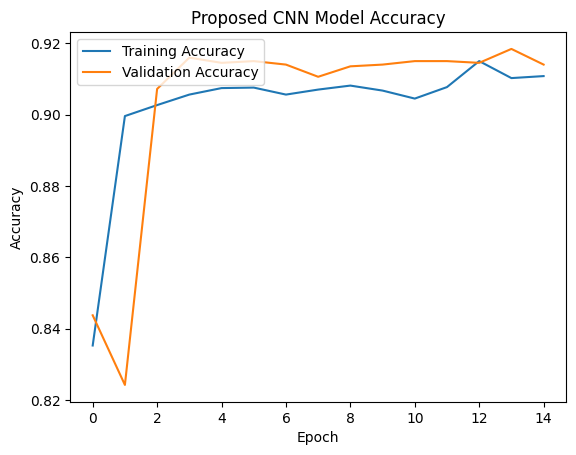

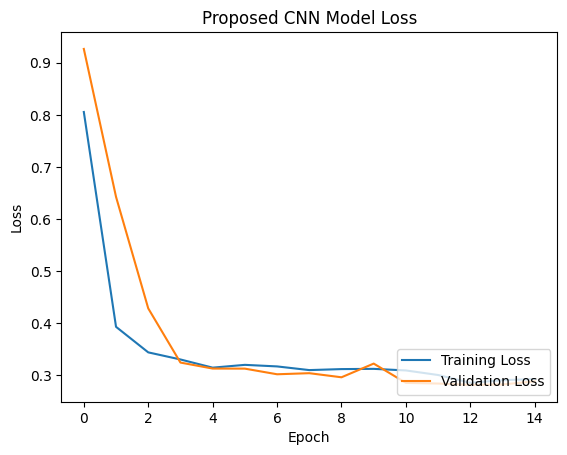

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_proposed_model_fit.history['accuracy'])
plt.plot(CNN_proposed_model_fit.history['val_accuracy'])
plt.title('Proposed CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_proposed_model_fit.history['loss'])
plt.plot(CNN_proposed_model_fit.history['val_loss'])
plt.title('Proposed CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Confusion Matrix

32/32 [==============================] - 1s 14ms/step


<ipython-input-26-df1a0c67c07d>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-26-df1a0c67c07d>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


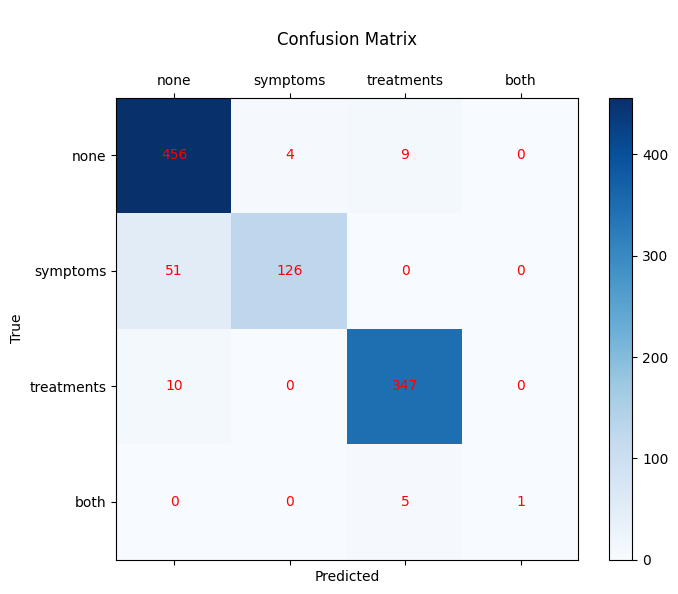

              precision    recall  f1-score   support

        none       0.88      0.97      0.92       469
    symptoms       0.97      0.71      0.82       177
  treatments       0.96      0.97      0.97       357
        both       1.00      0.17      0.29         6

    accuracy                           0.92      1009
   macro avg       0.95      0.71      0.75      1009
weighted avg       0.93      0.92      0.92      1009



In [ ]:
# Make predictions on the testing data
y_pred = CNN_proposed_model.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_test is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


In [ ]:
explainer = shap.Explainer(CNN_proposed_model, X_train[:100])
shap_values = explainer.shap_values(X_test[:100])


PermutationExplainer explainer: 101it [27:47, 16.68s/it]


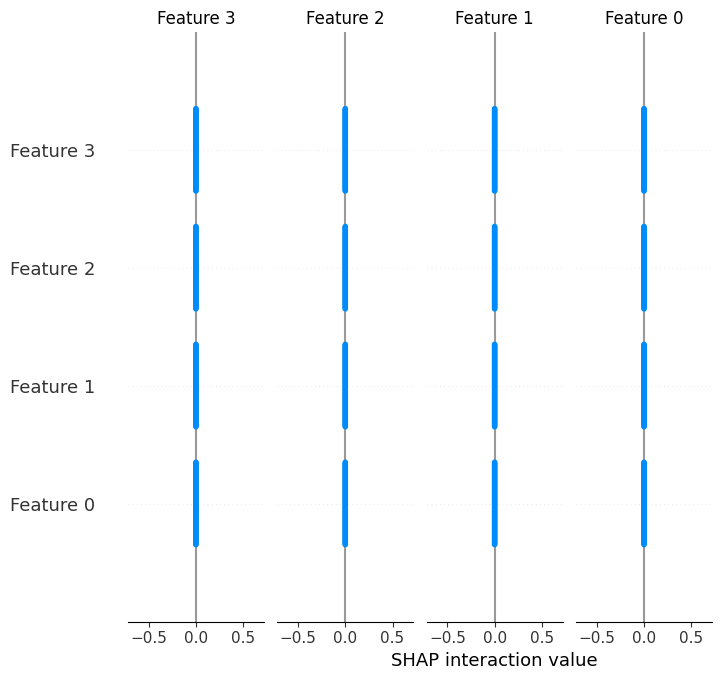

In [ ]:
shap.summary_plot(shap_values, X_test[:100])

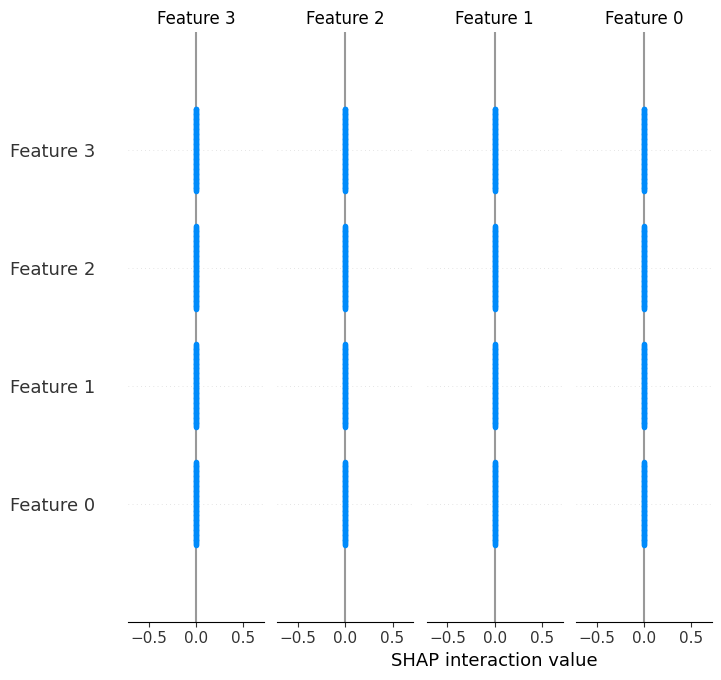

In [ ]:
shap.summary_plot(shap_values)

In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=082b462a87515e3abb6c6125a8151b1c2dd853f79aaec0140ccd8f3c4a26c0b8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Choose an instance to explain
idx = 42
instance = X_test[idx]

# Convert instance to string if needed
instance = instance.decode('utf-8')  # Assuming instance is a bytes-like object, adjust as needed

# Generate explanation with at most 10 features
exp = explainer.explain_instance(instance, CNN_proposed_model.predict, num_features=10)

# Show the explanation
exp.show_in_notebook()


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

## Proposed CNN + Word2Vec Embedding


### Building Word2Vec Embedding (with trainable set to false)

In [ ]:
# Define the Word2Vec model
sentences = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in X_train]
#train word2vec model
embedding_dims = 100 #embedding vector output dimension
max_len = 100 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences, vector_size= embedding_dims, window=5, workers=4, min_count=1)
# Get the vocabulary size
words = list(word2VecModel.wv.key_to_index)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 99


In [ ]:
# Get vocabulary from Word2Vec model
vocabulary = word2VecModel.wv.index_to_key

# Initialize embedding matrix
num_words = len(vocabulary) + 1  # Add 1 for padding token
embedding_matrix = np.zeros((num_words, embedding_dims))

# Fill embedding matrix
for i, word in enumerate(vocabulary):
    if word in word2VecModel.wv:
        embedding_matrix[i] = word2VecModel.wv[word]

# Optionally handle missing words (out of vocabulary)

# Print shape of embedding matrix
print("Shape of embedding matrix:", embedding_matrix.shape)


Shape of embedding matrix: (100, 100)


In [ ]:
#vocab size
words = list(word2VecModel.wv.key_to_index)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 99


In [ ]:
embedding_matrix.shape[0]

100

In [ ]:
CNN_Word2Vec_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(4, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

In [ ]:
CNN_Word2Vec_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_2 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_2 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_2 (Gl  (None, 100)              

In [ ]:
CNN_Word2Vec_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_fit = CNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
223/223 [==============================] - 9s 33ms/step - loss: 1.8945 - accuracy: 0.4370 - val_loss: 1.7321 - val_accuracy: 0.4966
Epoch 2/15
223/223 [==============================] - 7s 30ms/step - loss: 1.5303 - accuracy: 0.4903 - val_loss: 1.5493 - val_accuracy: 0.4692
Epoch 3/15
223/223 [==============================] - 7s 32ms/step - loss: 1.3635 - accuracy: 0.4989 - val_loss: 1.3239 - val_accuracy: 0.5181
Epoch 4/15
223/223 [==============================] - 6s 29ms/step - loss: 1.2549 - accuracy: 0.5201 - val_loss: 1.2539 - val_accuracy: 0.5293
Epoch 5/15
223/223 [==============================] - 7s 31ms/step - loss: 1.1843 - accuracy: 0.5166 - val_loss: 1.1533 - val_accuracy: 0.5093
Epoch 6/15
223/223 [==============================] - 6s 29ms/step - loss: 1.1306 - accuracy: 0.5148 - val_loss: 1.1189 - val_accuracy: 0.5205
Epoch 7/15
223/223 [==============================] - 7s 31ms/step - loss: 1.0990 - accuracy: 0.5217 - val_loss: 1.0855 - val_accuracy: 0.5107

In [ ]:
CNN_Word2Vec_train_score = CNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_train_score[1])

223/223 [==============================] - 3s 10ms/step - loss: 0.9969 - accuracy: 0.5519
Train Loss: 0.9968717694282532
Train Accuracy: 0.5519416928291321


In [ ]:
CNN_Word2Vec_test_score = CNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_test_score[1])

32/32 [==============================] - 0s 8ms/step - loss: 1.0122 - accuracy: 0.5164
Test Loss: 1.0121629238128662
Test Accuracy: 0.5163528323173523


In [ ]:
#Predicting......
print('Predicting....')
y_pred = CNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
32/32 [==============================] - 0s 8ms/step


#### Visualization on Testing and Validation Result

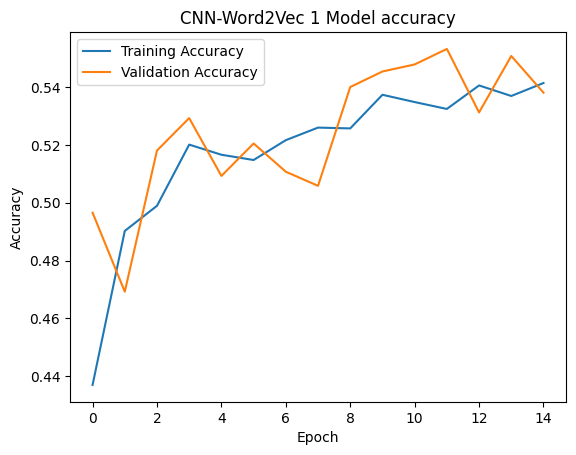

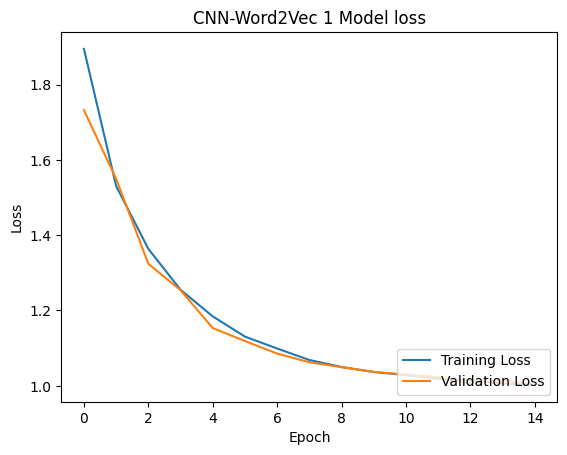

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit.history['accuracy'])
plt.plot(CNN_Word2Vec_model_fit.history['val_accuracy'])
plt.title('CNN-Word2Vec 1 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_fit.history['val_loss'])
plt.title('CNN-Word2Vec 1 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 0s 8ms/step


<ipython-input-41-e11721d7da05>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-41-e11721d7da05>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


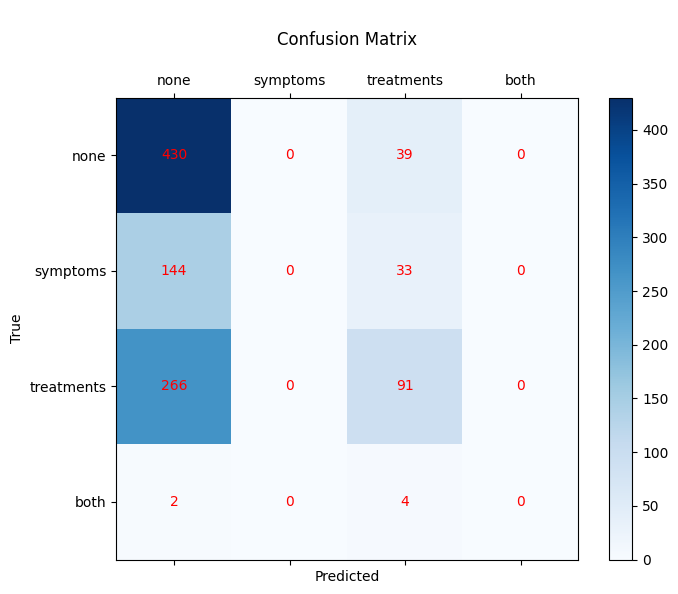

              precision    recall  f1-score   support

        none       0.51      0.92      0.66       469
    symptoms       0.00      0.00      0.00       177
  treatments       0.54      0.25      0.35       357
        both       0.00      0.00      0.00         6

    accuracy                           0.52      1009
   macro avg       0.26      0.29      0.25      1009
weighted avg       0.43      0.52      0.43      1009



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the testing data
y_pred = CNN_Word2Vec_model.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Building Word2Vec Embedding (with trainable set to True)

In [ ]:
CNN_Word2Vec_model_2 = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(4, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_Word2Vec_model_2.summary()
CNN_Word2Vec_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
CNN_Word2Vec_model_2_fit = CNN_Word2Vec_model_2.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

In [ ]:
CNN_Word2Vec_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_3 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_3 (Gl  (None, 100)              

In [ ]:
CNN_Word2Vec_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_2_fit = CNN_Word2Vec_model_2.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
223/223 [==============================] - 9s 32ms/step - loss: 1.7495 - accuracy: 0.4929 - val_loss: 1.6493 - val_accuracy: 0.6025
Epoch 2/15
223/223 [==============================] - 9s 40ms/step - loss: 1.0803 - accuracy: 0.7207 - val_loss: 0.8858 - val_accuracy: 0.8589
Epoch 3/15
223/223 [==============================] - 7s 31ms/step - loss: 0.6190 - accuracy: 0.8783 - val_loss: 0.5646 - val_accuracy: 0.9111
Epoch 4/15
223/223 [==============================] - 9s 40ms/step - loss: 0.4986 - accuracy: 0.8975 - val_loss: 0.4656 - val_accuracy: 0.9165
Epoch 5/15
223/223 [==============================] - 8s 37ms/step - loss: 0.4290 - accuracy: 0.9040 - val_loss: 0.4139 - val_accuracy: 0.9150
Epoch 6/15
223/223 [==============================] - 8s 34ms/step - loss: 0.3849 - accuracy: 0.9035 - val_loss: 0.3809 - val_accuracy: 0.9150
Epoch 7/15
223/223 [==============================] - 9s 40ms/step - loss: 0.3611 - accuracy: 0.9051 - val_loss: 0.3791 - val_accuracy: 0.9136

In [ ]:
CNN_Word2Vec_2_train_score = CNN_Word2Vec_model_2.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_2_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_2_train_score[1])

223/223 [==============================] - 3s 14ms/step - loss: 0.3152 - accuracy: 0.9149
Train Loss: 0.3152053654193878
Train Accuracy: 0.9149025678634644


In [ ]:
CNN_Word2Vec_2_test_score = CNN_Word2Vec_model_2.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_2_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_2_test_score[1])

32/32 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.9217
Test Loss: 0.31340664625167847
Test Accuracy: 0.9217046499252319


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#### Visualization on Testing and Validation Result

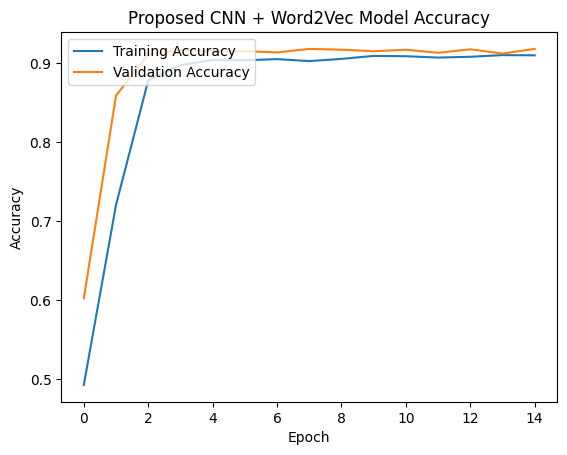

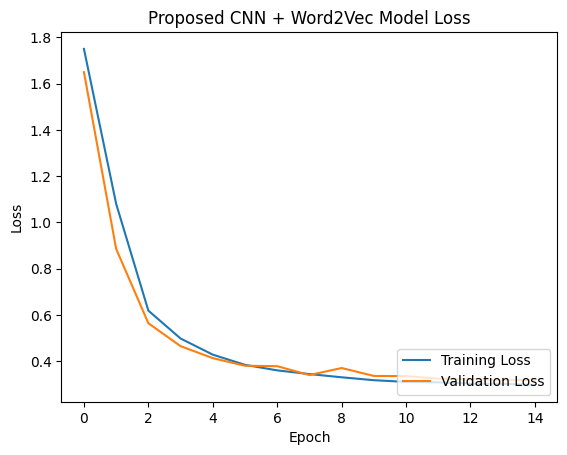

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_2_fit.history['accuracy'])
plt.plot(CNN_Word2Vec_model_2_fit.history['val_accuracy'])
plt.title('Proposed CNN + Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_2_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_2_fit.history['val_loss'])
plt.title('Proposed CNN + Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 0s 8ms/step


<ipython-input-52-60025e3d1d52>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-52-60025e3d1d52>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


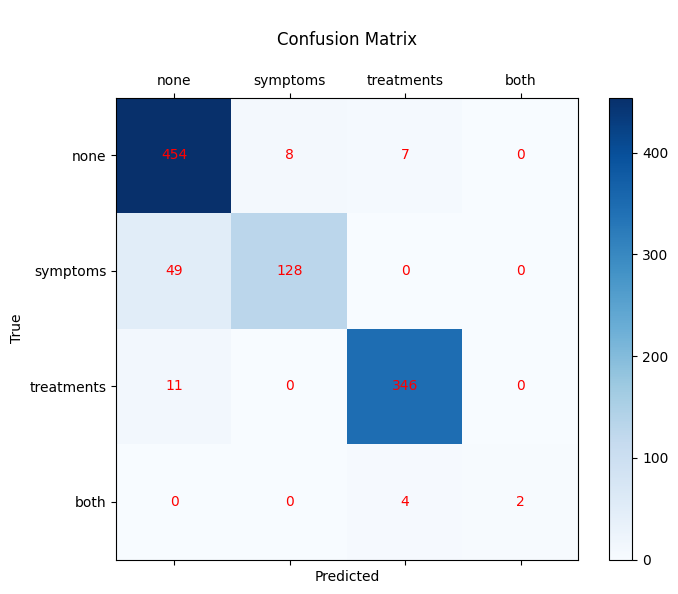

              precision    recall  f1-score   support

        none       0.88      0.97      0.92       469
    symptoms       0.94      0.72      0.82       177
  treatments       0.97      0.97      0.97       357
        both       1.00      0.33      0.50         6

    accuracy                           0.92      1009
   macro avg       0.95      0.75      0.80      1009
weighted avg       0.92      0.92      0.92      1009



In [ ]:
# Make predictions on the testing data
y_pred = CNN_Word2Vec_model_2.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Building Word2Vec Embedding (with trainable set to True) have underfitting need to modify

In [ ]:
CNN_Word2Vec_model_2 = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(20, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
CNN_Word2Vec_model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_13 (Spat  (None, 100, 100)          0         
 ialDropout1D)                                                   
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 100)          40100     
                                                                 
 batch_normalization_13 (Ba  (None, 100, 100)          400       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_13 (G  (None, 100)             

In [ ]:
CNN_Word2Vec_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_2_fit = CNN_Word2Vec_model_2.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
179/179 [==============================] - 10s 48ms/step - loss: 1.1300 - accuracy: 0.4811 - val_loss: 1.1253 - val_accuracy: 0.6587
Epoch 2/15
179/179 [==============================] - 8s 43ms/step - loss: 0.6122 - accuracy: 0.7550 - val_loss: 0.6603 - val_accuracy: 0.8192
Epoch 3/15
179/179 [==============================] - 6s 32ms/step - loss: 0.4424 - accuracy: 0.8458 - val_loss: 0.4060 - val_accuracy: 0.9033
Epoch 4/15
179/179 [==============================] - 8s 47ms/step - loss: 0.3606 - accuracy: 0.8903 - val_loss: 0.3284 - val_accuracy: 0.9082
Epoch 5/15
179/179 [==============================] - 5s 30ms/step - loss: 0.3321 - accuracy: 0.8940 - val_loss: 0.3427 - val_accuracy: 0.9061
Epoch 6/15
179/179 [==============================] - 7s 37ms/step - loss: 0.3220 - accuracy: 0.8994 - val_loss: 0.3104 - val_accuracy: 0.9068
Epoch 7/15
179/179 [==============================] - 7s 40ms/step - loss: 0.3128 - accuracy: 0.9008 - val_loss: 0.3862 - val_accuracy: 0.904

In [ ]:
CNN_Word2Vec_2_train_score = CNN_Word2Vec_model_2.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_2_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_2_train_score[1])

179/179 [==============================] - 2s 11ms/step - loss: 0.2969 - accuracy: 0.9140
Train Loss: 0.2968873977661133
Train Accuracy: 0.9139502048492432


In [ ]:
CNN_Word2Vec_2_test_score = CNN_Word2Vec_model_2.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_2_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_2_test_score[1])

96/96 [==============================] - 1s 8ms/step - loss: 0.3076 - accuracy: 0.9149
Test Loss: 0.30761387944221497
Test Accuracy: 0.9149492979049683


In [ ]:
#Predicting......
print('Predicting....')
y_pred = CNN_Word2Vec_model_2.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
96/96 [==============================] - 1s 8ms/step


#### Visualization on Testing and Validation Result

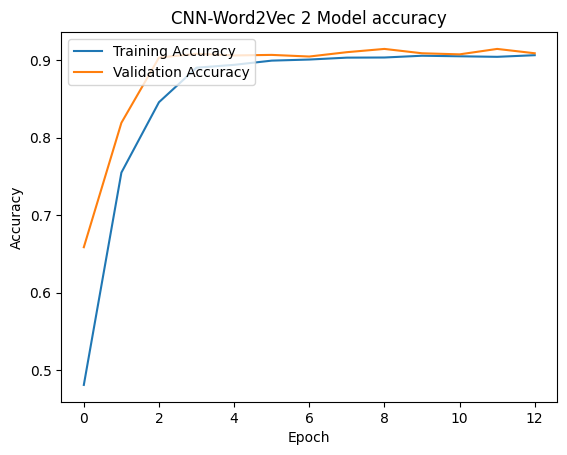

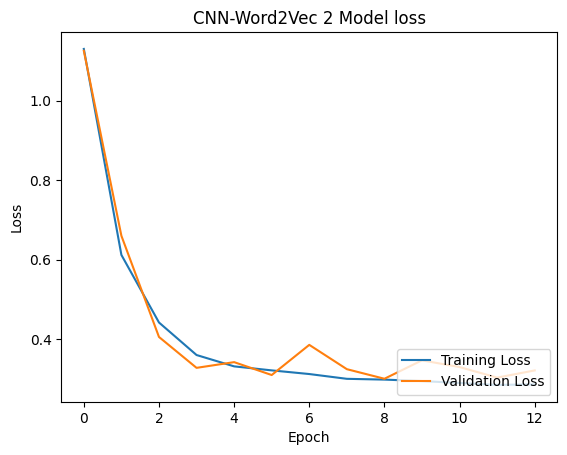

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_2_fit.history['accuracy'])
plt.plot(CNN_Word2Vec_model_2_fit.history['val_accuracy'])
plt.title('CNN-Word2Vec 2 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_2_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_2_fit.history['val_loss'])
plt.title('CNN-Word2Vec 2 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

45/45 [==============================] - 1s 14ms/step


<ipython-input-198-2c41999b5057>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-198-2c41999b5057>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


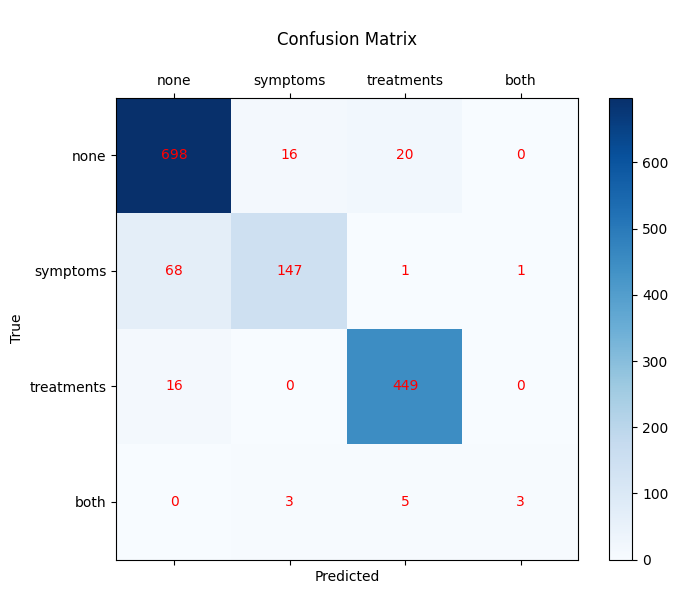

              precision    recall  f1-score   support

        none       0.89      0.95      0.92       734
    symptoms       0.89      0.68      0.77       217
  treatments       0.95      0.97      0.96       465
        both       0.75      0.27      0.40        11

    accuracy                           0.91      1427
   macro avg       0.87      0.72      0.76      1427
weighted avg       0.91      0.91      0.90      1427



In [ ]:
# Make predictions on the validation data
y_pred = CNN_Word2Vec_model_2.predict(X_val)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_val

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


## Proposed CNN + Pre-trained Word2Vec Model

In [ ]:
# Load the pre-trained Word2Vec model
import gensim.downloader as api

word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Building Pre-trained Word2Vec Embedding (with trainable set to False)

In [ ]:
# Create the embedding matrix
word_index = tokenizer.word_index
embedding_dims = 300  # Word embedding dimension
num_words = len(word_index) + 1  # Vocabulary size + 1 for padding

pretrained_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_vector = word2vec_model[word]
        pretrained_embedding_matrix[i] = embedding_vector

In [ ]:
pretrained_embedding_matrix.shape

(13368, 300)

In [ ]:
CNN_pretrained_Word2Vec_model = Sequential([
    Embedding(input_dim =pretrained_embedding_matrix.shape[0], input_length=max_len, output_dim=pretrained_embedding_matrix.shape[1],weights=[pretrained_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(4, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

In [ ]:
CNN_pretrained_Word2Vec_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          4010400   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 100, 300)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 100)          120100    
                                                                 
 batch_normalization_4 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 100)              

In [ ]:
CNN_pretrained_Word2Vec_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_pretrained_Word2Vec_model_fit = CNN_pretrained_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
223/223 [==============================] - 16s 61ms/step - loss: 1.6068 - accuracy: 0.7575 - val_loss: 0.9379 - val_accuracy: 0.8101
Epoch 2/15
223/223 [==============================] - 13s 60ms/step - loss: 0.6501 - accuracy: 0.8440 - val_loss: 0.5761 - val_accuracy: 0.8452
Epoch 3/15
223/223 [==============================] - 13s 58ms/step - loss: 0.5300 - accuracy: 0.8542 - val_loss: 0.4394 - val_accuracy: 0.8818
Epoch 4/15
223/223 [==============================] - 13s 60ms/step - loss: 0.4789 - accuracy: 0.8616 - val_loss: 0.3966 - val_accuracy: 0.8921
Epoch 5/15
223/223 [==============================] - 14s 61ms/step - loss: 0.4508 - accuracy: 0.8665 - val_loss: 0.3916 - val_accuracy: 0.8872
Epoch 6/15
223/223 [==============================] - 14s 62ms/step - loss: 0.4434 - accuracy: 0.8724 - val_loss: 0.4081 - val_accuracy: 0.8799
Epoch 7/15
223/223 [==============================] - 14s 63ms/step - loss: 0.4299 - accuracy: 0.8723 - val_loss: 0.4352 - val_accuracy:

In [ ]:
CNN_pretrained_Word2Vec_train_score = CNN_pretrained_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_pretrained_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_pretrained_Word2Vec_train_score[1])

223/223 [==============================] - 6s 27ms/step - loss: 0.3430 - accuracy: 0.8944
Train Loss: 0.34304288029670715
Train Accuracy: 0.8944343328475952


In [ ]:
CNN_pretrained_Word2Vec_test_score = CNN_pretrained_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_pretrained_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_pretrained_Word2Vec_test_score[1])

32/32 [==============================] - 1s 18ms/step - loss: 0.3828 - accuracy: 0.8910
Test Loss: 0.3828403949737549
Test Accuracy: 0.8909811973571777


#### Visualization on Testing and Validation Result

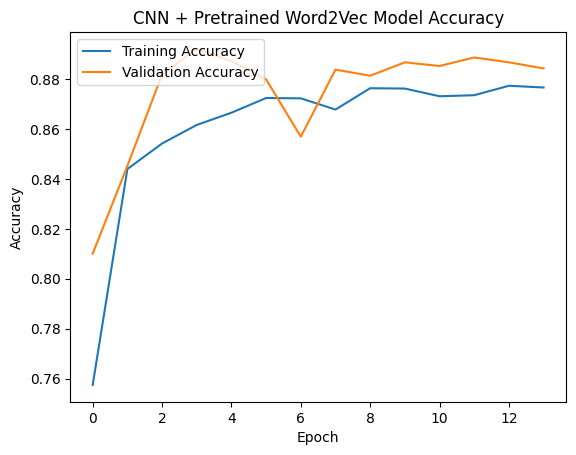

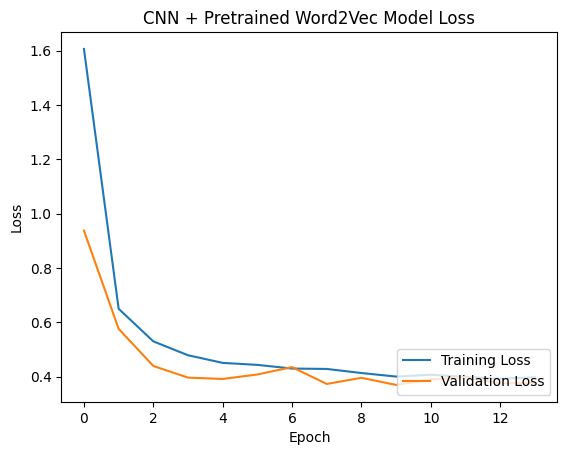

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_pretrained_Word2Vec_model_fit.history['accuracy'])
plt.plot(CNN_pretrained_Word2Vec_model_fit.history['val_accuracy'])
plt.title('CNN + Pretrained Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_pretrained_Word2Vec_model_fit.history['loss'])
plt.plot(CNN_pretrained_Word2Vec_model_fit.history['val_loss'])
plt.title('CNN + Pretrained Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 17ms/step


<ipython-input-62-70c9c53e900c>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-62-70c9c53e900c>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


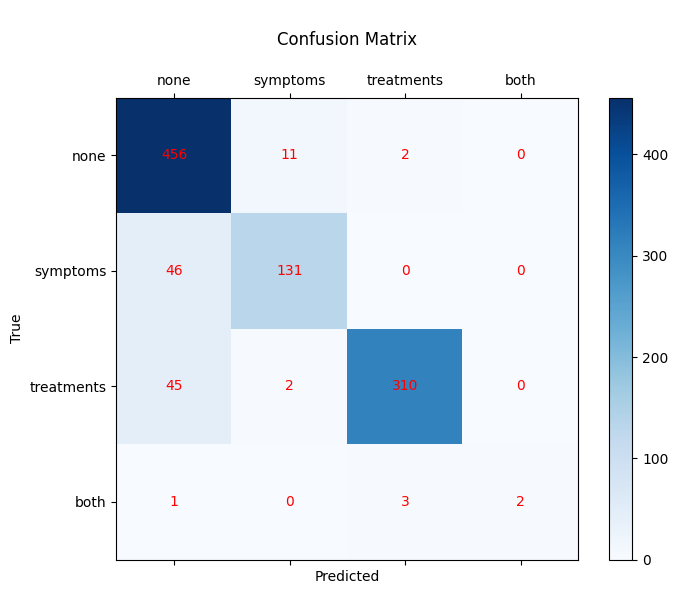

              precision    recall  f1-score   support

        none       0.83      0.97      0.90       469
    symptoms       0.91      0.74      0.82       177
  treatments       0.98      0.87      0.92       357
        both       1.00      0.33      0.50         6

    accuracy                           0.89      1009
   macro avg       0.93      0.73      0.78      1009
weighted avg       0.90      0.89      0.89      1009



In [ ]:
# Make predictions on the testing data
y_pred = CNN_pretrained_Word2Vec_model.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Building Pre-trained Word2Vec Embedding (with trainable set to True)

In [ ]:
CNN_pretrained_Word2Vec_model_2 = Sequential([
    Embedding(input_dim =pretrained_embedding_matrix.shape[0], input_length=max_len, output_dim=pretrained_embedding_matrix.shape[1],weights=[pretrained_embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(4, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

In [ ]:
CNN_pretrained_Word2Vec_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4010400   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 300)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 100)          120100    
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 100)              

In [ ]:
CNN_pretrained_Word2Vec_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_pretrained_Word2Vec_model_2_fit = CNN_pretrained_Word2Vec_model_2.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
223/223 [==============================] - 44s 188ms/step - loss: 1.1821 - accuracy: 0.8117 - val_loss: 0.6209 - val_accuracy: 0.9102
Epoch 2/15
223/223 [==============================] - 30s 136ms/step - loss: 0.4589 - accuracy: 0.8984 - val_loss: 0.3762 - val_accuracy: 0.9116
Epoch 3/15
223/223 [==============================] - 30s 135ms/step - loss: 0.3740 - accuracy: 0.9003 - val_loss: 0.3190 - val_accuracy: 0.9180
Epoch 4/15
223/223 [==============================] - 30s 136ms/step - loss: 0.3345 - accuracy: 0.9041 - val_loss: 0.3162 - val_accuracy: 0.9121
Epoch 5/15
223/223 [==============================] - 30s 133ms/step - loss: 0.3299 - accuracy: 0.9034 - val_loss: 0.2944 - val_accuracy: 0.9146
Epoch 6/15
223/223 [==============================] - 29s 132ms/step - loss: 0.3094 - accuracy: 0.9097 - val_loss: 0.3032 - val_accuracy: 0.9180
Epoch 7/15
223/223 [==============================] - 30s 133ms/step - loss: 0.3090 - accuracy: 0.9083 - val_loss: 0.2806 - val_ac

In [ ]:
CNN_pretrained_Word2Vec_2_train_score = CNN_pretrained_Word2Vec_model_2.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_pretrained_Word2Vec_2_train_score[0])
print('Train Accuracy:', CNN_pretrained_Word2Vec_2_train_score[1])

223/223 [==============================] - 6s 25ms/step - loss: 0.2797 - accuracy: 0.9145
Train Loss: 0.2796986699104309
Train Accuracy: 0.9144819974899292


In [ ]:
CNN_pretrained_Word2Vec_2_test_score = CNN_pretrained_Word2Vec_model_2.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_pretrained_Word2Vec_2_test_score[0])
print('Test Accuracy:', CNN_pretrained_Word2Vec_2_test_score[1])

32/32 [==============================] - 1s 17ms/step - loss: 0.2904 - accuracy: 0.9187
Test Loss: 0.29041528701782227
Test Accuracy: 0.9187313914299011


#### Visualization on Testing and Validation Result

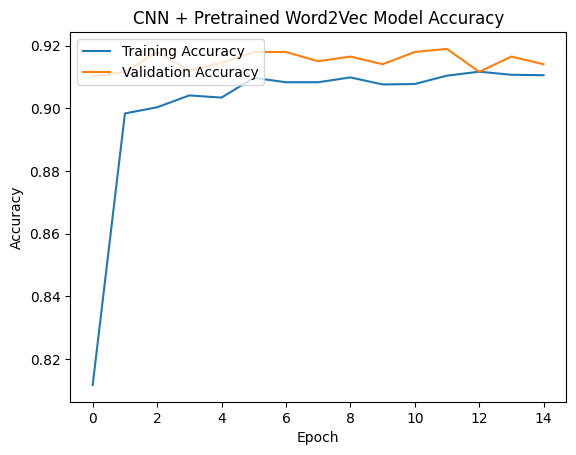

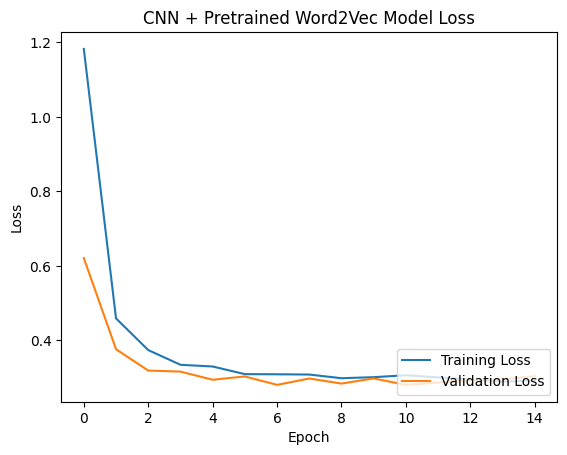

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_pretrained_Word2Vec_model_2_fit.history['accuracy'])
plt.plot(CNN_pretrained_Word2Vec_model_2_fit.history['val_accuracy'])
plt.title('CNN + Pretrained Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_pretrained_Word2Vec_model_2_fit.history['loss'])
plt.plot(CNN_pretrained_Word2Vec_model_2_fit.history['val_loss'])
plt.title('CNN + Pretrained Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 26ms/step


<ipython-input-27-0d1d2489ce2c>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-27-0d1d2489ce2c>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


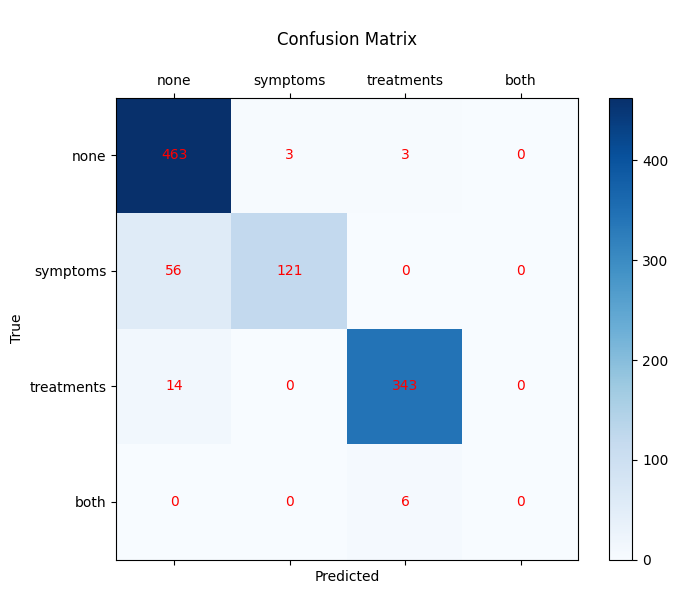

              precision    recall  f1-score   support

        none       0.87      0.99      0.92       469
    symptoms       0.98      0.68      0.80       177
  treatments       0.97      0.96      0.97       357
        both       0.00      0.00      0.00         6

    accuracy                           0.92      1009
   macro avg       0.70      0.66      0.67      1009
weighted avg       0.92      0.92      0.91      1009



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the testing data
y_pred = CNN_pretrained_Word2Vec_model_2.predict(X_test)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


## GLOVE Pre-trained

In [ ]:
#upload the pre-trained glove file
from google.colab import files

uploaded = files.upload()

Saving glove.6B.100d.txt to glove.6B.100d.txt


In [ ]:
glove_path = 'glove.6B.100d.txt'

In [ ]:
# Create an empty dictionary to hold the embeddings
embeddings_index = {}

# Open the GloVe file and read it line by line
with open(glove_path, encoding="utf8") as glove_file:
    for line in glove_file:
        # Split the line into the word and its vector representation
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix
pretrained_glove_embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
pretrained_glove_embedding_matrix.shape

(13368, 100)

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

### set trainaible to false

In [ ]:
CNN_Glove_model = Sequential([
    Embedding(input_dim =pretrained_glove_embedding_matrix.shape[0], input_length=max_len, output_dim=pretrained_glove_embedding_matrix.shape[1],weights=[pretrained_glove_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [ ]:
CNN_Glove_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1336800   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_3 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_3 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                      

In [ ]:
CNN_Glove_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_Glove_model_fit = CNN_Glove_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
179/179 [==============================] - 6s 25ms/step - loss: 1.3412 - accuracy: 0.4881 - val_loss: 1.1303 - val_accuracy: 0.5144
Epoch 2/15
179/179 [==============================] - 4s 22ms/step - loss: 1.1161 - accuracy: 0.4881 - val_loss: 1.0682 - val_accuracy: 0.5144
Epoch 3/15
179/179 [==============================] - 8s 46ms/step - loss: 1.0846 - accuracy: 0.4881 - val_loss: 1.0510 - val_accuracy: 0.5144
Epoch 4/15
179/179 [==============================] - 9s 50ms/step - loss: 1.0745 - accuracy: 0.4881 - val_loss: 1.0456 - val_accuracy: 0.5144
Epoch 5/15
179/179 [==============================] - 9s 51ms/step - loss: 1.0695 - accuracy: 0.4881 - val_loss: 1.0415 - val_accuracy: 0.5144
Epoch 6/15
179/179 [==============================] - 5s 28ms/step - loss: 1.0672 - accuracy: 0.4881 - val_loss: 1.0417 - val_accuracy: 0.5144
Epoch 7/15
179/179 [==============================] - 4s 24ms/step - loss: 1.0655 - accuracy: 0.4881 - val_loss: 1.0403 - val_accuracy: 0.5144

In [ ]:
X_train

array([[ 0,  0,  0, ..., 72,  1,  4],
       [ 0,  0,  0, ...,  3,  4, 90],
       [ 0,  0,  0, ...,  0,  0,  7],
       ...,
       [ 0,  0,  0, ..., 32, 47, 30],
       [ 0,  0,  0, ...,  6, 13, 64],
       [ 0,  0,  0, ...,  0, 27,  9]], dtype=int32)

In [ ]:
CNN_Glove_model_train_score = CNN_Glove_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Glove_model_train_score[0])
print('Train Accuracy:', CNN_Glove_model_train_score[1])

179/179 [==============================] - 2s 13ms/step - loss: 1.0608 - accuracy: 0.4881
Train Loss: 1.060803771018982
Train Accuracy: 0.4880827069282532


In [ ]:
CNN_Glove_model_test_score = CNN_Glove_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Glove_model_test_score[0])
print('Test Accuracy:', CNN_Glove_model_test_score[1])

96/96 [==============================] - 1s 15ms/step - loss: 1.0589 - accuracy: 0.4845
Test Loss: 1.0589162111282349
Test Accuracy: 0.4844619035720825


#### Visualization on Testing and Validation Result

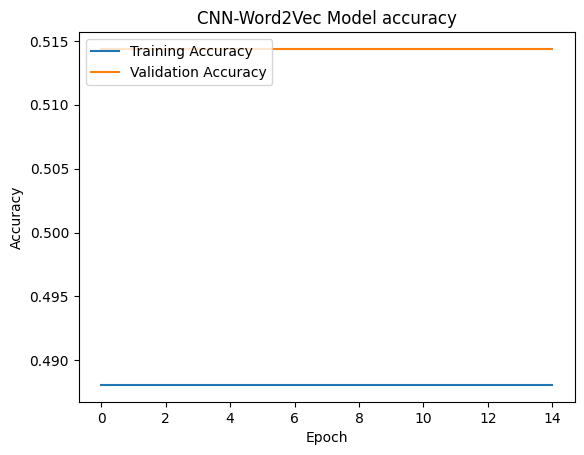

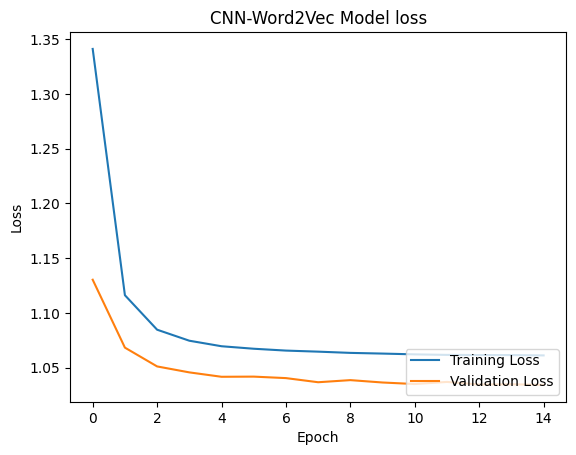

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Glove_model_fit.history['accuracy'])
plt.plot(CNN_Glove_model_fit.history['val_accuracy'])
plt.title('CNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Glove_model_fit.history['loss'])
plt.plot(CNN_Glove_model_fit.history['val_loss'])
plt.title('CNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

45/45 [==============================] - 1s 16ms/step


<ipython-input-90-5c4c167c7c80>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-90-5c4c167c7c80>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


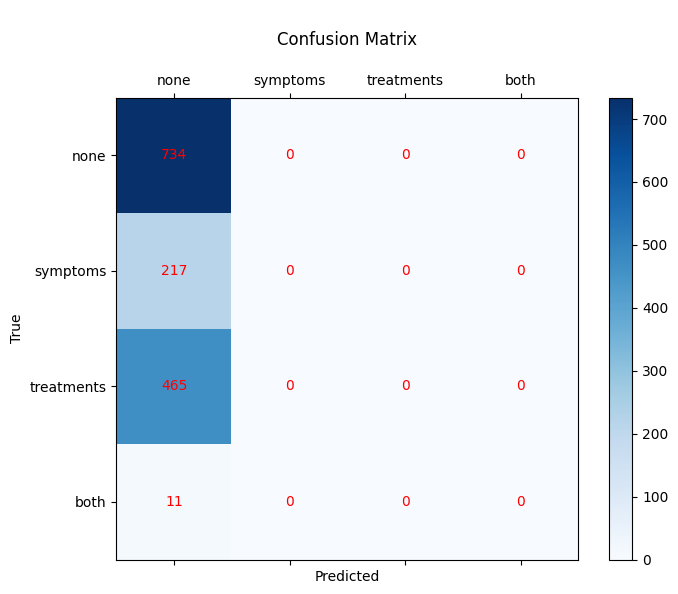

              precision    recall  f1-score   support

        none       0.51      1.00      0.68       734
    symptoms       0.00      0.00      0.00       217
  treatments       0.00      0.00      0.00       465
        both       0.00      0.00      0.00        11

    accuracy                           0.51      1427
   macro avg       0.13      0.25      0.17      1427
weighted avg       0.26      0.51      0.35      1427



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the validation data
y_pred = CNN_Glove_model.predict(X_val)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_val

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### set trainaible to true

In [ ]:
pretrained_glove_embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
CNN_Glove_model_2 = Sequential([
    Embedding(input_dim =pretrained_glove_embedding_matrix.shape[0], input_length=max_len, output_dim=pretrained_glove_embedding_matrix.shape[1],weights=[pretrained_glove_embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(20, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
CNN_Glove_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1336800   
                                                                 
 spatial_dropout1d_6 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_6 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_6 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                      

In [ ]:
CNN_Glove_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Glove_model_fit_2 = CNN_Glove_model_2.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/15
179/179 [==============================] - 12s 58ms/step - loss: 1.3395 - accuracy: 0.4881 - val_loss: 1.2918 - val_accuracy: 0.5144
Epoch 2/15
179/179 [==============================] - 8s 45ms/step - loss: 1.2659 - accuracy: 0.4881 - val_loss: 1.2264 - val_accuracy: 0.5144
Epoch 3/15
179/179 [==============================] - 12s 67ms/step - loss: 1.2152 - accuracy: 0.4881 - val_loss: 1.1805 - val_accuracy: 0.5144
Epoch 4/15
179/179 [==============================] - 7s 40ms/step - loss: 1.1795 - accuracy: 0.4881 - val_loss: 1.1476 - val_accuracy: 0.5144
Epoch 5/15
179/179 [==============================] - 11s 63ms/step - loss: 1.1540 - accuracy: 0.4881 - val_loss: 1.1236 - val_accuracy: 0.5144
Epoch 6/15
179/179 [==============================] - 8s 42ms/step - loss: 1.1352 - accuracy: 0.4881 - val_loss: 1.1060 - val_accuracy: 0.5144
Epoch 7/15
179/179 [==============================] - 10s 56ms/step - loss: 1.1212 - accuracy: 0.4881 - val_loss: 1.0927 - val_accuracy: 0.

In [ ]:
CNN_Glove_model_2_train_score = CNN_Glove_model_2.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Glove_model_2_train_score[0])
print('Train Accuracy:', CNN_Glove_model_2_train_score[1])

179/179 [==============================] - 2s 13ms/step - loss: 1.0608 - accuracy: 0.4881
Train Loss: 1.060803771018982
Train Accuracy: 0.4880827069282532


In [ ]:
CNN_Glove_model_2_test_score = CNN_Glove_model_2.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Glove_model_2_test_score[0])
print('Test Accuracy:', CNN_Glove_model_2_test_score[1])

96/96 [==============================] - 1s 15ms/step - loss: 1.0589 - accuracy: 0.4845
Test Loss: 1.0589162111282349
Test Accuracy: 0.4844619035720825


#### Visualization on Testing and Validation Result

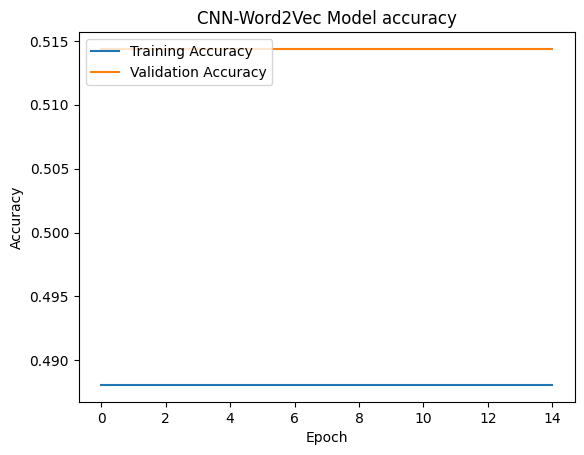

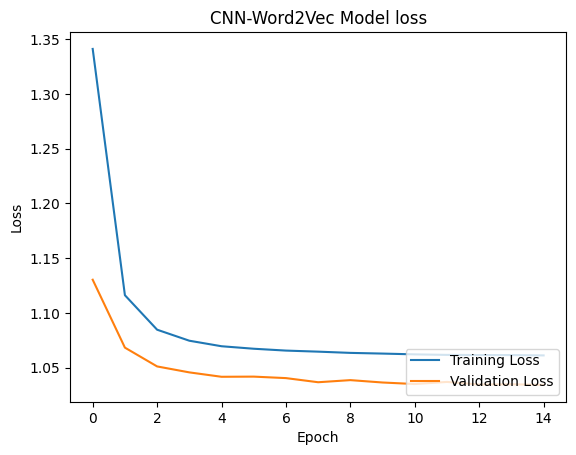

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Glove_model_fit_2.history['accuracy'])
plt.plot(CNN_Glove_model_fit_2.history['val_accuracy'])
plt.title('CNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Glove_model_fit_2.history['loss'])
plt.plot(CNN_Glove_model_fit_2.history['val_loss'])
plt.title('CNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

#### Confusion Matrix

45/45 [==============================] - 1s 16ms/step


<ipython-input-90-5c4c167c7c80>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-90-5c4c167c7c80>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


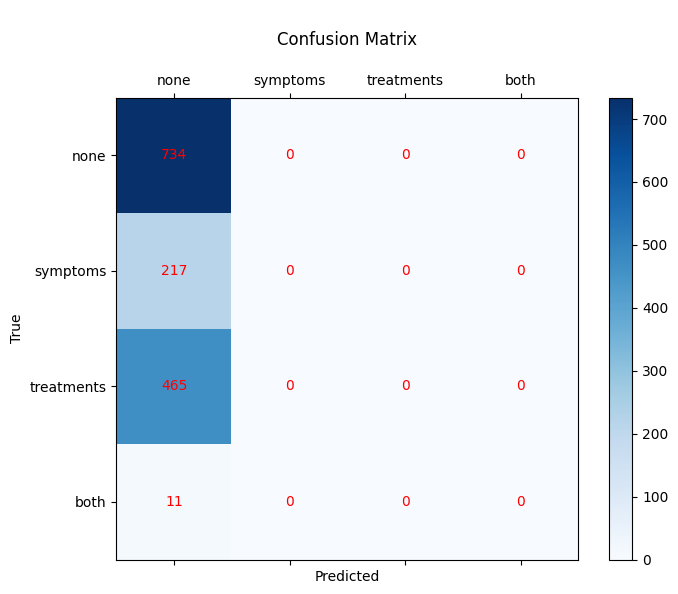

              precision    recall  f1-score   support

        none       0.51      1.00      0.68       734
    symptoms       0.00      0.00      0.00       217
  treatments       0.00      0.00      0.00       465
        both       0.00      0.00      0.00        11

    accuracy                           0.51      1427
   macro avg       0.13      0.25      0.17      1427
weighted avg       0.26      0.51      0.35      1427



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the validation data
y_pred = CNN_Glove_model_2.predict(X_val)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_val

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments', 3: 'both'}
    label_names = ['none', 'symptoms', 'treatments', 'both']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


# Visuailization on Four Models' Training Loss and Accuracy

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_author_fit.history['accuracy'])
plt.plot(CNN_model_author_fit.history['val_accuracy'])
plt.title('Convolutional Neural Network (CNN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

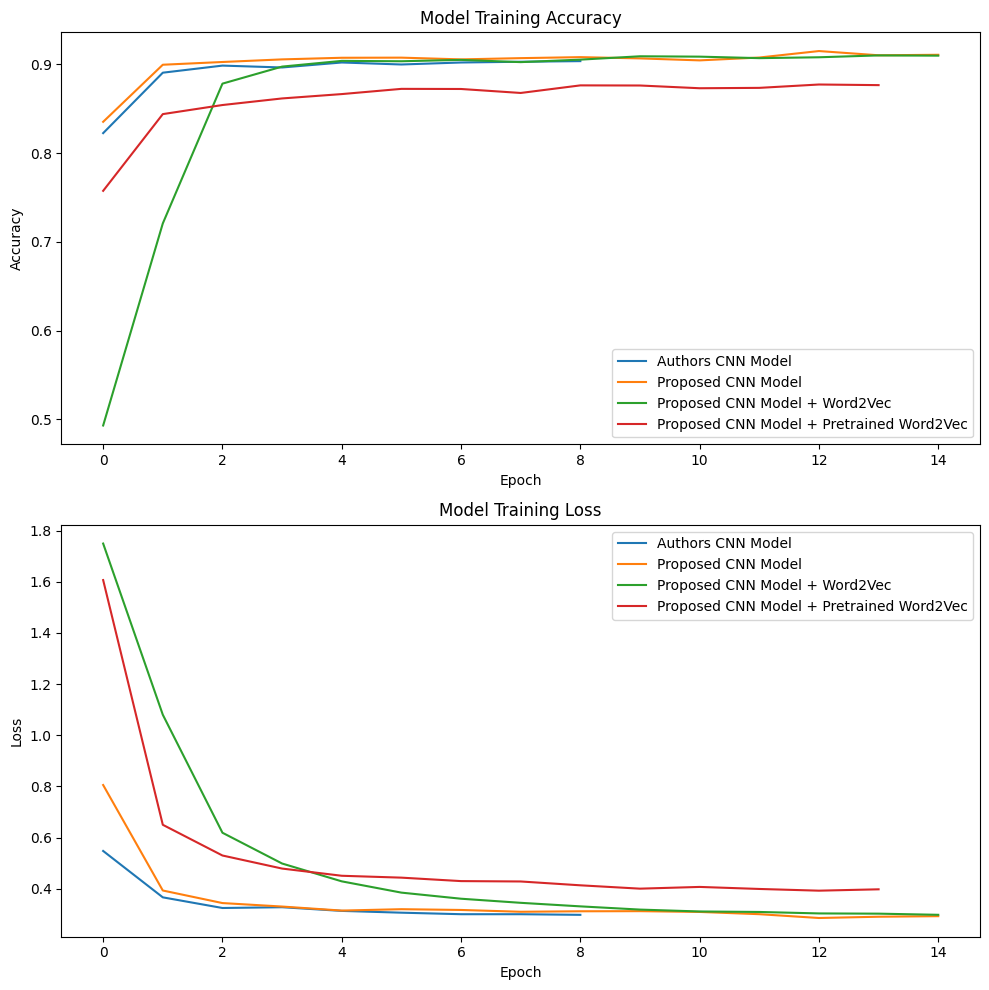

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot training accuracy values for all models
axs[0].plot(CNN_model_author_fit.history['accuracy'],label='Authors CNN Model')
axs[0].plot(CNN_proposed_model_fit.history['accuracy'], label='Proposed CNN Model')
axs[0].plot(CNN_Word2Vec_model_2_fit.history['accuracy'], label='Proposed CNN Model + Word2Vec')
axs[0].plot(CNN_pretrained_Word2Vec_model_fit.history['accuracy'], label='Proposed CNN Model + Pretrained Word2Vec')
axs[0].set_title('Model Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training loss values for all models
axs[1].plot(CNN_model_author_fit.history['loss'], label='Authors CNN Model')
axs[1].plot(CNN_proposed_model_fit.history['loss'], label='Proposed CNN Model')
axs[1].plot(CNN_Word2Vec_model_2_fit.history['loss'], label='Proposed CNN Model + Word2Vec')
axs[1].plot(CNN_pretrained_Word2Vec_model_fit.history['loss'], label='Proposed CNN Model + Pretrained Word2Vec')
axs[1].set_title('Model Training Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


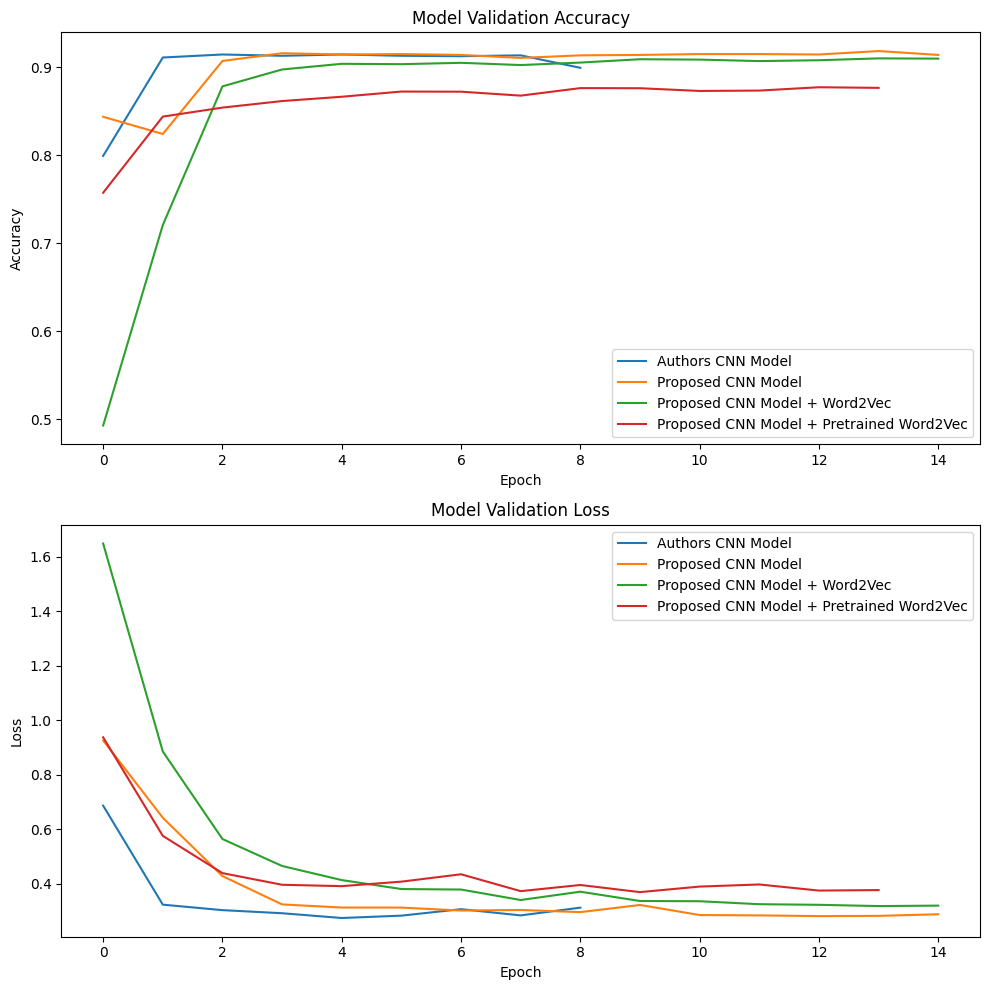

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot validation accuracy values for all models
axs[0].plot(CNN_model_author_fit.history['val_accuracy'],label='Authors CNN Model')
axs[0].plot(CNN_proposed_model_fit.history['val_accuracy'], label='Proposed CNN Model')
axs[0].plot(CNN_Word2Vec_model_2_fit.history['accuracy'], label='Proposed CNN Model + Word2Vec')
axs[0].plot(CNN_pretrained_Word2Vec_model_fit.history['accuracy'], label='Proposed CNN Model + Pretrained Word2Vec')
axs[0].set_title('Model Validation Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot validation loss values for all models
axs[1].plot(CNN_model_author_fit.history['val_loss'], label='Authors CNN Model')
axs[1].plot(CNN_proposed_model_fit.history['val_loss'], label='Proposed CNN Model')
axs[1].plot(CNN_Word2Vec_model_2_fit.history['val_loss'], label='Proposed CNN Model + Word2Vec')
axs[1].plot(CNN_pretrained_Word2Vec_model_fit.history['val_loss'], label='Proposed CNN Model + Pretrained Word2Vec')
axs[1].set_title('Model Validation Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()
